# How to quickly compute drawdown? 

In this notebook, we show several different implementations for maximum drawdown. We show that one method is significantly faster than the other. 

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline

In [23]:
# 
input_file = "C:\dev\quant_research\data\ETFs.csv"


In [3]:
df = pd.read_csv(input_file, usecols = ["dts", "SPY"]).rename(columns={"dts":"date", "SPY":"spy"})
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

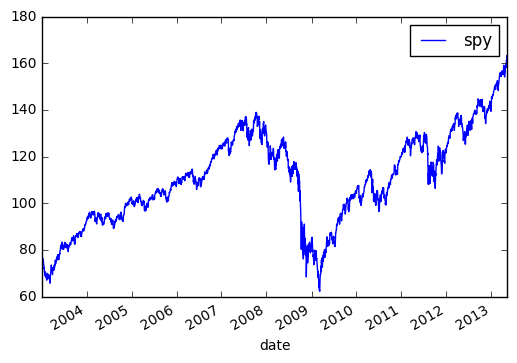

In [4]:
df.set_index("date").plot()

In [6]:
def maxdrawdown1(arr):
    """
    array of prices.
    Time complexity: O(n^2)
    """
    maxdd =0
    for i in range(len(arr)): 
        for j in range(i, len(arr)):
            dd = (arr[i]-arr[j])/arr[i]
            maxdd = max(dd, maxdd)
    return maxdd, i, j

def maxdrawdown2(arr):
    """array of prices"""
    # get running maximum 
    running_max = np.maximum.accumulate(arr)
    # find the drawdown ending index 
    i = np.argmax((running_max - arr)/running_max )
    # now find the drawdown starting index 
    j = np.argmax(arr[:i])
    return (arr[j]-arr[i])/arr[j], i, j 


def maxdrawdown3(df,col_val,col_date):
    """find maximum drawdown when input is a data frame"""
    res = df[[col_date,col_val]]
    res['rel_max'] = pd.expanding_max(res[col_val])
    res['drawdown'] = 1 - res[col_val] / res['rel_max']
    maxdd = res['drawdown'].max()    
    
    idx_bottom = res['drawdown'].argmax()
    date_bottom = res.ix[idx_bottom][col_date]  # trough

    idx_top = res.loc[:idx_bottom, col_val].argmax()
    date_top = res.ix[idx_top][col_date]  # peak

    return date_top,date_bottom,maxdd     


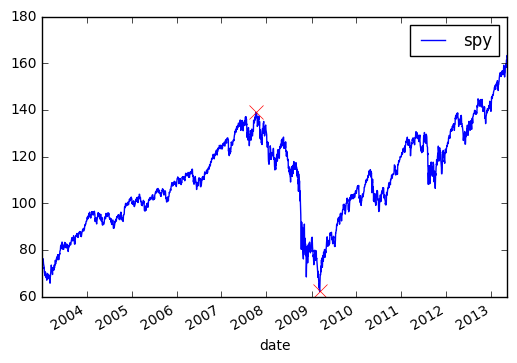

In [20]:
import matplotlib.pyplot as plt 
arr = df["spy"]
maxdd, i, j = maxdrawdown2(arr)

#plt.plot(np.arange(len(arr)), arr)
df.set_index("date").plot()
plt.plot([df["date"].iloc[i], df["date"].iloc[j]], [arr[i], arr[j]],
         'x', color='Red', markersize=10)

In [28]:
import timeit, functools

arr = np.array(df["spy"])    
t = timeit.Timer(functools.partial(maxdrawdown2, arr)) 
t.timeit(number=100)


0.00901592829677611

In [29]:
res_map = {}
for l in range(50, 2500, 50):
    arr = np.array(df["spy"].iloc[-l:])
    
    t1 = timeit.Timer(functools.partial(maxdrawdown1, arr)) #O(N^2)
    
    t2 = timeit.Timer(functools.partial(maxdrawdown2, arr)) #O(3*N)
    
    res_map[l] = {"time1":t1.timeit(number=1), "time2":t2.timeit(number=1)}
df_res = pd.DataFrame(res_map).T


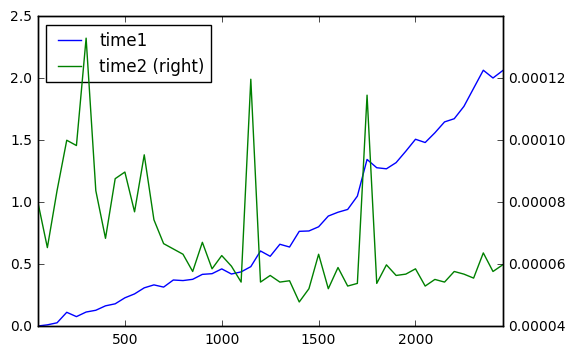

In [48]:
df_res[["time1","time2"]].plot(secondary_y="time2")